# Google Authentication and file download

In [1]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data files
downloaded = drive.CreateFile({'id':"1bk_Ed_s668afxSM8U76s0U0nMUHBt-2h"})
downloaded.GetContentFile('PB2Data.zip')

# Extract files to
with zipfile.ZipFile('PB2Data.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from librosa.display import specshow
import librosa
import pickle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt

# Hyper-parameters 

In [3]:
lowpass_cutoff = 2000 # Cutt off for low pass filter
downsample_rate = 9600 # Frequency to downsample to
nyquist_rate = 2400 # Nyquist rate (half of sampling rate)
segment_duration = 4 # how long should a segment be
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 600 # Spectrogram, minimum frequency for call
f_max = 2500 # Spectrogram, maximum frequency for call
save_results_folder = 'Saved_Data'

# Read pickle files

In [4]:
input_file_X = open('/content/Saved_Data/X.pkl','rb')
X = pickle.load(input_file_X)
input_file_X.close()

In [5]:
X.shape

(3049, 38400)

In [6]:
input_file_Y = open('/content/Saved_Data/Y.pkl','rb')
Y = pickle.load(input_file_Y)
input_file_Y.close()

In [7]:
Y.shape

(3049,)

In [8]:
Y

array(['gibbon', 'gibbon', 'gibbon', ..., 'no-gibbon', 'no-gibbon',
       'no-gibbon'], dtype='<U9')

In [9]:
np.unique(Y, return_counts=True)

(array(['gibbon', 'no-gibbon'], dtype='<U9'), array([ 761, 2288]))

▶ There are 761 instances for the 'gibbon' class and 2288 instances for the 'no-gibbon' class. The number of additional 'gibbon' instances needed to balance the two classes is 1527

# Pre-processing

### Create `balance_dataset` function



In [10]:
def balance_dataset(x, y, number_samples, test_function=False):
  generated_x = []
  generated_y = []

  for _ in range(number_samples):
    # find the index of gibbon calls
    y_gibbon = np.where(y == 'gibbon')
    # Randomly select an index
    select_gibbon_file = np.random.randint(0, len(y_gibbon[0])-1)
    # Use index to find corresponding audio
    a1 = x[y_gibbon[0][select_gibbon_file]]

    # find the index of non-gibbon calls
    y_non_gibbon = np.where(y == 'no-gibbon')
    # Randomly select an index
    select_non_gibbon_file = np.random.randint(0, len(y_non_gibbon[0])-1)
    # use index to find corresponding audio
    a2 = x[y_non_gibbon[0][select_non_gibbon_file]]

    # Generate Gaussian noise with mean 0, std 0.1 and length 4 seconds
    a3 = np.random.normal(0, 0.1 ,38400)

    # add variability to data to improve model robustness
    # prevent synthetics samples from begin too similar (i.e. using fixed weights)
    w1 = np.random.uniform(0.8, 1)
    w2 = np.random.uniform(0.1, 0.5)
    w3 = np.random.uniform(0, 0.2)

    synthetic_audio = a1*w1 + a2*w2 + a3*w3
    label = 'gibbon'

    # Generate sample for testing
    if test_function == True:
      return synthetic_audio, label, a1, a2
      break

    else:
      generated_x.append(synthetic_audio)
      generated_y.append(label)

  return np.asarray(generated_x), np.asarray(generated_y)

### Generate an example to test the `balance_dataset` function

In [11]:
synthetic_gibbon_call, synthetic_gibbon_label, random_gibbon_call, no_gibbon_call = balance_dataset(X, Y, 1, True)

In [12]:
synthetic_gibbon_call_spectrum = librosa.feature.melspectrogram(synthetic_gibbon_call, sr=9600, hop_length=hop_length, n_mels=n_mels)
random_gibbon_call_spectrum = librosa.feature.melspectrogram(random_gibbon_call, sr=9600, hop_length=hop_length, n_mels=n_mels)
no_gibbon_call_spectrum = librosa.feature.melspectrogram(no_gibbon_call, sr=9600, hop_length=hop_length, n_mels=n_mels)

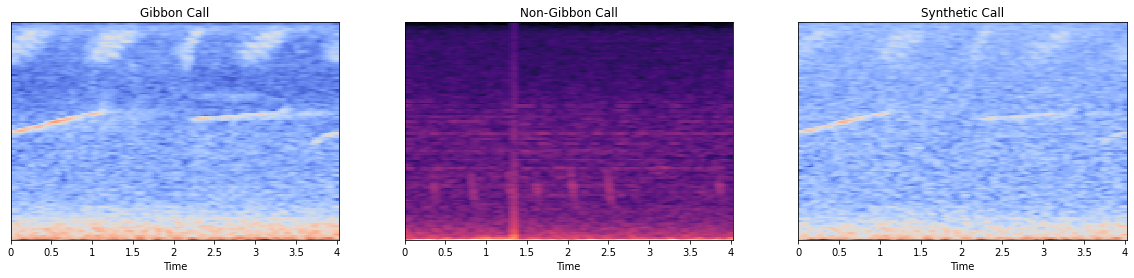

In [13]:
plt.figure(figsize=(20, 4))

# Gibbon call
ax = plt.subplot(1, 3, 1)
specshow(librosa.power_to_db(random_gibbon_call_spectrum), 
         x_axis='time', 
         sr=9600, 
         hop_length=hop_length )
plt.title("Gibbon Call")

# No-Gibbon call
ax = plt.subplot(1, 3, 2)
specshow(librosa.power_to_db(no_gibbon_call_spectrum), 
         x_axis='time', 
         sr=9600, 
         hop_length=hop_length )
plt.title("Non-Gibbon Call")

# Synthetic data
ax = plt.subplot(1, 3, 3)
specshow(librosa.power_to_db(synthetic_gibbon_call_spectrum), 
         x_axis='time', 
         sr=9600, 
         hop_length=hop_length )
plt.title("Synthetic Call")

plt.show()

### Generate a balanced dataset

In [14]:
synthetic_data = balance_dataset(X,Y,1527)

In [15]:
X = np.append(X, synthetic_data[0], axis=0)
Y = np.append(Y, synthetic_data[1], axis=0)

In [16]:
print('Length of X: ', len(X))
print('Length of Y: ', len(Y))

Length of X:  4576
Length of Y:  4576


In [17]:
# check Y values
np.unique(Y, return_counts=True)

(array(['gibbon', 'no-gibbon'], dtype='<U9'), array([2288, 2288]))

### Create low pass Butterworth filter

In [18]:
def butter_lowpass(cutoff, nyq_freq, order):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = filtfilt(b, a, data)
    return y

### Ceate downsampling function

In [19]:
def downsample(amplitudes, original_sr, new_sample_rate, res_type='kaiser_fast'):
  sample = librosa.resample(y = amplitudes, 
                            orig_sr = original_sr, 
                            target_sr = new_sample_rate, 
                            res_type = res_type)
  return np.asarray(sample)

### Create a conversion to Mel-spectrograms with normalisation

In [20]:
def convert_single_to_image(audio, n_fft, hop_length, n_mels):
    '''
    Convert amplitude values into a mel-spectrogram.
    '''
    # generate spectrogram
    S = librosa.feature.melspectrogram(audio, n_fft=n_fft,hop_length=hop_length, 
                                        n_mels=n_mels)
    
    # Normalise image
    image = librosa.core.power_to_db(S)
    image_np = np.asmatrix(image)
    image_np_scaled_temp = (image_np - np.min(image_np))
    image_np_scaled = image_np_scaled_temp / np.max(image_np_scaled_temp)
    mean = image.flatten().mean()
    std = image.flatten().std()
    eps=1e-8
    spec_norm = (image - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
    S1 = spec_scaled
    
    return S1

In [21]:
def convert_all_to_image(segments, n_fft, hop_length, n_mels):
    '''
    Convert a number of segments into their corresponding spectrograms.
    '''
    spectrograms = []
    for segment in segments:
        spectrograms.append(convert_single_to_image(segment, n_fft, hop_length, n_mels))

    return np.array(spectrograms)

### Apply Butterworth filter

In [22]:
X = butter_lowpass_filter(X, lowpass_cutoff, nyquist_rate, order=4)

### Apply downsampling

In [23]:
X = downsample(X, downsample_rate, nyquist_rate*2)

In [24]:
print('Shape of X: ', X.shape)
print('Shape of Y: ', Y.shape)

Shape of X:  (4576, 19200)
Shape of Y:  (4576,)


### Apply Mel spectrogram conversion

In [25]:
X = convert_all_to_image(X, n_fft, hop_length, n_mels)

In [26]:
X.shape

(4576, 128, 76)

In [27]:
# Add depth
X = np.stack((X, X, X), axis = 3)

In [28]:
X.shape

(4576, 128, 76, 3)

### Target pre-processing

In [29]:
# Encode Y values as gibbon = 1 and non-gibbon = 0
Y = np.where(Y=='gibbon',1,0)

In [30]:
np.unique(Y, return_counts=True)

(array([0, 1]), array([2288, 2288]))

In [31]:
Y.shape

(4576,)

### Train validation split

In [32]:
# Generate train and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.33, random_state=42) 

In [33]:
print('X_train shape:',X_train.shape)
print('Y_train shape:',Y_train.shape)

print()

print('X_val shape:',X_val.shape)
print('Y_val shape:',Y_val.shape)

X_train shape: (3065, 128, 76, 3)
Y_train shape: (3065,)

X_val shape: (1511, 128, 76, 3)
Y_val shape: (1511,)


# Reset and re-intiate session  variables

In [34]:
# save datasets as numpy files
np.save('X_train',X_train)
np.save('X_val',X_val)
np.save('Y_train',Y_train)
np.save('Y_val',Y_val)

In [35]:
# reset all varaiables to free up RAM
%reset -sf

## Imports

In [36]:
from librosa.display import specshow
import librosa
import numpy as np
import os
import math
from keras.layers import GlobalMaxPooling2D, Dense
from keras.models import Model
from keras.applications import ResNet101V2, VGG16, Xception, InceptionResNetV2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import clear_session
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.metrics import accuracy_score

In [37]:
# reload datasets from file
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
Y_train = np.load('Y_train.npy')
Y_val = np.load('Y_val.npy')

## Hyperparamters

In [38]:
lowpass_cutoff = 2000 # Cutt off for low pass filter
downsample_rate = 9600 # Frequency to downsample to
nyquist_rate = 2400 # Nyquist rate (half of sampling rate)
segment_duration = 4 # how long should a segment be
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 600 # Spectrogram, minimum frequency for call
f_max = 2500 # Spectrogram, maximum frequency for call
save_results_folder = 'Saved_Data'

## Create low pass Butterworth filter

In [39]:
def butter_lowpass(cutoff, nyq_freq, order):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = filtfilt(b, a, data)
    return y

## Ceate downsampling function

In [40]:
def downsample(amplitudes, original_sr, new_sample_rate, res_type='kaiser_fast'):
  sample = librosa.resample(y = amplitudes, 
                            orig_sr = original_sr, 
                            target_sr = new_sample_rate, 
                            res_type = res_type)
  return np.asarray(sample)

## Convert to Mel-spectrograms and normalise

In [41]:
def convert_single_to_image(audio, n_fft, hop_length, n_mels):

    '''
    Convert amplitude values into a mel-spectrogram.
    '''
    S = librosa.feature.melspectrogram(audio, n_fft=n_fft,hop_length=hop_length, 
                                        n_mels=n_mels)
    
    image = librosa.core.power_to_db(S)
    image_np = np.asmatrix(image)
    image_np_scaled_temp = (image_np - np.min(image_np))
    image_np_scaled = image_np_scaled_temp / np.max(image_np_scaled_temp)
    mean = image.flatten().mean()
    std = image.flatten().std()
    eps=1e-8
    spec_norm = (image - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
    S1 = spec_scaled
    
    return S1

# Model development

The model development section includes:
* Apply 4 models pre-trained on ImageNet dataset
    *   Use Sigmoid as final classificaion output layer
    *   Use binary_crossentropy as loss function
    *   Apply early stopping and model checkpoints

The models to be tested include:
1.   ResNet101V2
2.   VGG16
3.   Xception
4.   InceptionResNetV2


In [42]:
!mkdir checkpoints
!mkdir checkpoints/ResNet101V2
!mkdir checkpoints/VGG16
!mkdir checkpoints/Xception
!mkdir checkpoints/InceptionResNetV2

## Define early stopping

In [43]:
es = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

## ResNet101V2

In [44]:
# With `clear_session()` called at the beginning,
# Keras starts with a blank state at each iteration
clear_session()

In [45]:
# Create checkpoint
checkpoint_ResNet101V2 = ModelCheckpoint(
    filepath = 'checkpoints/ResNet101V2/epoch{epoch:02d}-val_acc{val_accuracy:.2f}.hdf5',
    monitor = "val_accuracy",
    save_best_only = True,
    save_weights_only= True,
    mode = "max",
    save_freq="epoch",
)

In [46]:
# Define model
model_ResNet101V2 = ResNet101V2(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 76, 3),
)

171317808/171317808 [==============================] - 5s 0us/step


In [47]:
# Freeze the feature extractor layers
model_ResNet101V2.trainable = False

In [48]:
# Add custom output layer
x = GlobalMaxPooling2D()(model_ResNet101V2.output)
output = Dense(1, activation="sigmoid", name = 'predictions')(x)

# Define the Model by combining the input and output
model1 = Model(inputs=model_ResNet101V2.input, outputs= output)

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 76, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 82, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 38, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 40, 64)   0           ['conv1_conv[0][0]']         

In [49]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
history1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=64, callbacks=[es, checkpoint_ResNet101V2] )

Epoch 1/100
48/48 [==============================] - 26s 208ms/step - loss: 0.3310 - accuracy: 0.8564 - val_loss: 0.1752 - val_accuracy: 0.9312
Epoch 2/100
48/48 [==============================] - 6s 128ms/step - loss: 0.1248 - accuracy: 0.9527 - val_loss: 0.1157 - val_accuracy: 0.9629
Epoch 3/100
48/48 [==============================] - 6s 131ms/step - loss: 0.0902 - accuracy: 0.9713 - val_loss: 0.0972 - val_accuracy: 0.9656
Epoch 4/100
48/48 [==============================] - 7s 150ms/step - loss: 0.0704 - accuracy: 0.9811 - val_loss: 0.0779 - val_accuracy: 0.9735
Epoch 5/100
48/48 [==============================] - 6s 129ms/step - loss: 0.0594 - accuracy: 0.9843 - val_loss: 0.0734 - val_accuracy: 0.9775
Epoch 6/100
48/48 [==============================] - 5s 106ms/step - loss: 0.0509 - accuracy: 0.9873 - val_loss: 0.0663 - val_accuracy: 0.9768
Epoch 7/100
48/48 [==============================] - 6s 136ms/step - loss: 0.0448 - accuracy: 0.9889 - val_loss: 0.0629 - val_accuracy: 0.979

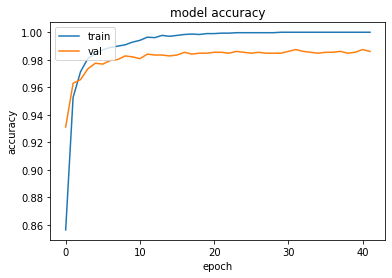

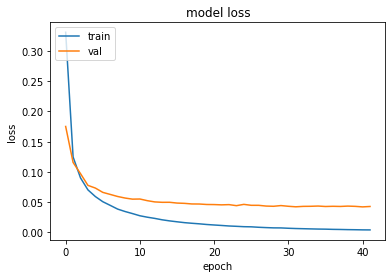

In [51]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## VGG16

In [52]:
# With `clear_session()` called at the beginning,
# Keras starts with a blank state at each iteration
clear_session()

In [53]:
# Create checkpoint
checkpoint_VGG16 = ModelCheckpoint(
    filepath = 'checkpoints/VGG16/epoch{epoch:02d}-val_acc{val_accuracy:.2f}.hdf5',
    monitor = "val_accuracy",
    save_best_only = True,
    save_weights_only= True,
    mode = "max",
    save_freq="epoch",
)

In [54]:
# Define model
model_VGG16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 76, 3),
)

58889256/58889256 [==============================] - 2s 0us/step


In [55]:
# Freeze the feature extractor layers
model_VGG16.trainable = False

In [56]:
# Create custom output layer
x = GlobalMaxPooling2D()(model_VGG16.output)
output = Dense(1, activation="sigmoid", name = 'predictions')(x)

# Define the Model by combining the input and output
model2 = Model(inputs=model_VGG16.input, outputs= output)

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 76, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 76, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 76, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 38, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 38, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 38, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 19, 128)       0     

In [57]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
history2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=64, callbacks=[es, checkpoint_VGG16] )

Epoch 1/100
48/48 [==============================] - 11s 178ms/step - loss: 0.6840 - accuracy: 0.5811 - val_loss: 0.5861 - val_accuracy: 0.7611
Epoch 2/100
48/48 [==============================] - 5s 103ms/step - loss: 0.5276 - accuracy: 0.9223 - val_loss: 0.4760 - val_accuracy: 0.9298
Epoch 3/100
48/48 [==============================] - 5s 103ms/step - loss: 0.4372 - accuracy: 0.9282 - val_loss: 0.4049 - val_accuracy: 0.9378
Epoch 4/100
48/48 [==============================] - 5s 100ms/step - loss: 0.3757 - accuracy: 0.9347 - val_loss: 0.3525 - val_accuracy: 0.9232
Epoch 5/100
48/48 [==============================] - 5s 100ms/step - loss: 0.3324 - accuracy: 0.9312 - val_loss: 0.3169 - val_accuracy: 0.9219
Epoch 6/100
48/48 [==============================] - 5s 100ms/step - loss: 0.3001 - accuracy: 0.9364 - val_loss: 0.2893 - val_accuracy: 0.9279
Epoch 7/100
48/48 [==============================] - 5s 100ms/step - loss: 0.2759 - accuracy: 0.9354 - val_loss: 0.2683 - val_accuracy: 0.934

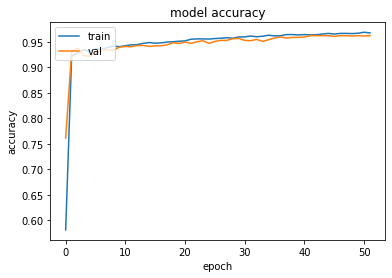

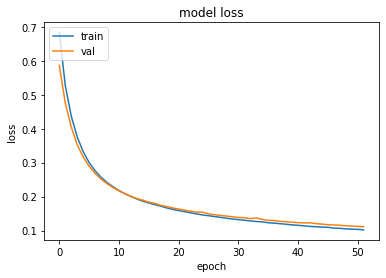

In [59]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Xception

In [60]:
# With `clear_session()` called at the beginning,
# Keras starts with a blank state at each iteration
clear_session()

In [61]:
# create checkpoint
checkpoint_Xception = ModelCheckpoint(
    filepath = 'checkpoints/Xception/epoch{epoch:02d}-val_acc{val_accuracy:.2f}.hdf5',
    monitor = "val_accuracy",
    save_best_only = True,
    save_weights_only= True,
    mode = "max",
    save_freq="epoch",
)

In [62]:
# Define model
model_Xception = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 76, 3),
)

83683744/83683744 [==============================] - 3s 0us/step


In [63]:
# Freeze the feature extractor layers
model_Xception.trainable = False

In [64]:
# Create custom output layer
x = GlobalMaxPooling2D()(model_Xception.output)
output = Dense(1, activation="sigmoid", name = 'predictions')(x)

# Define the Model by combining the input and output
model3 = Model(inputs=model_Xception.input, outputs= output)

model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 76, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 37, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [65]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
history3 = model3.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=64, callbacks=[es, checkpoint_Xception] )

Epoch 1/100
48/48 [==============================] - 10s 138ms/step - loss: 0.4068 - accuracy: 0.8418 - val_loss: 0.2877 - val_accuracy: 0.9100
Epoch 2/100
48/48 [==============================] - 4s 92ms/step - loss: 0.2579 - accuracy: 0.9142 - val_loss: 0.2282 - val_accuracy: 0.9239
Epoch 3/100
48/48 [==============================] - 4s 92ms/step - loss: 0.2161 - accuracy: 0.9302 - val_loss: 0.2006 - val_accuracy: 0.9285
Epoch 4/100
48/48 [==============================] - 4s 91ms/step - loss: 0.1938 - accuracy: 0.9370 - val_loss: 0.1817 - val_accuracy: 0.9365
Epoch 5/100
48/48 [==============================] - 4s 92ms/step - loss: 0.1754 - accuracy: 0.9423 - val_loss: 0.1689 - val_accuracy: 0.9404
Epoch 6/100
48/48 [==============================] - 4s 93ms/step - loss: 0.1626 - accuracy: 0.9481 - val_loss: 0.1602 - val_accuracy: 0.9477
Epoch 7/100
48/48 [==============================] - 4s 83ms/step - loss: 0.1518 - accuracy: 0.9546 - val_loss: 0.1506 - val_accuracy: 0.9457
Epoc

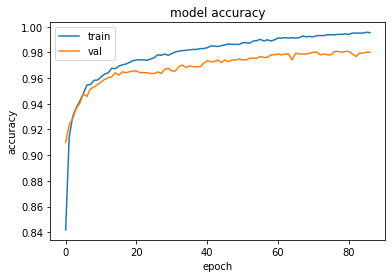

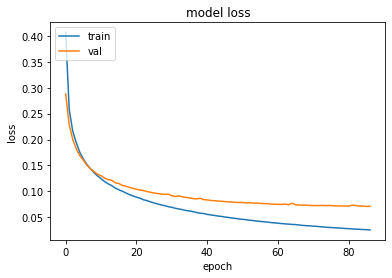

In [67]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## InceptionResNetV2

In [68]:
# With `clear_session()` called at the beginning,
# Keras starts with a blank state at each iteration
clear_session()

In [69]:
# Create checkpoint
checkpoint_InceptionResNetV2 = ModelCheckpoint(
    filepath = 'checkpoints/InceptionResNetV2/epoch{epoch:02d}-val_acc{val_accuracy:.2f}.hdf5',
    monitor = "val_accuracy",
    save_best_only = True,
    save_weights_only= True,
    mode = "max",
    save_freq="epoch",
)

In [70]:
# Define model
model_InceptionResNetV2 = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 76, 3),
)

219055592/219055592 [==============================] - 6s 0us/step


In [71]:
# Freeze the feature extractor layers
model_InceptionResNetV2.trainable = False

In [72]:
# Create custom output layer
x = GlobalMaxPooling2D()(model_InceptionResNetV2.output)
output = Dense(1, activation="sigmoid", name = 'predictions')(x)

# Define the Model by combining the input and output
model4 = Model(inputs=model_InceptionResNetV2.input, outputs= output)

model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 76, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 63, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [73]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
history4 = model4.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=64, callbacks=[es, checkpoint_InceptionResNetV2] )

Epoch 1/100
48/48 [==============================] - 25s 251ms/step - loss: 0.6125 - accuracy: 0.6460 - val_loss: 0.5647 - val_accuracy: 0.7340
Epoch 2/100
48/48 [==============================] - 7s 143ms/step - loss: 0.5414 - accuracy: 0.7550 - val_loss: 0.5200 - val_accuracy: 0.7763
Epoch 3/100
48/48 [==============================] - 7s 143ms/step - loss: 0.5064 - accuracy: 0.7889 - val_loss: 0.4967 - val_accuracy: 0.7988
Epoch 4/100
48/48 [==============================] - 7s 142ms/step - loss: 0.4842 - accuracy: 0.7977 - val_loss: 0.4777 - val_accuracy: 0.8101
Epoch 5/100
48/48 [==============================] - 7s 144ms/step - loss: 0.4667 - accuracy: 0.8072 - val_loss: 0.4639 - val_accuracy: 0.8147
Epoch 6/100
48/48 [==============================] - 7s 144ms/step - loss: 0.4529 - accuracy: 0.8147 - val_loss: 0.4532 - val_accuracy: 0.8206
Epoch 7/100
48/48 [==============================] - 7s 144ms/step - loss: 0.4411 - accuracy: 0.8196 - val_loss: 0.4437 - val_accuracy: 0.830

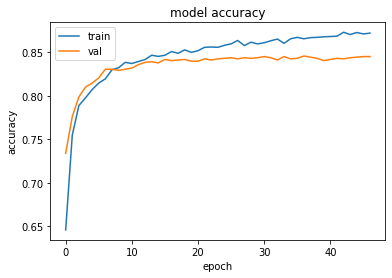

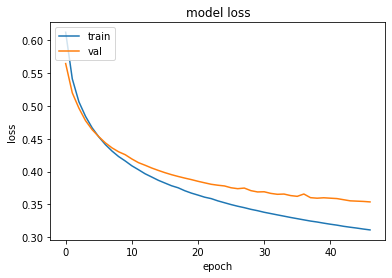

In [75]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Best performing mode is VGG16

VGG16 has a good val_accuracy score and when taking into consideration the training and validation curves for model loss and model accuravy, VGG16 is the best performing model as it has the least amount of overfitting

# Predictions on testing files

Representation of check2.wav for testing purposes

In [76]:
check2 = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [77]:
def predict_on_entire_file(audio, sample_rate, model):
    
    # Duration of file
    file_duration = len(audio)/sample_rate
    
    # Number of segments
    segments = math.floor(file_duration) - 4
    
    # Store predictions in this list
    predictions = []

    # Loop over the file and work in small "segments"
    for position in range (0, segments):

        # Determine start of segment
        start_position = position
        
        # Determine end of segment
        end_position = start_position + 4

        print('start position:', start_position)
        print('end position:', end_position)

        # Extract a 4 second segment from the audio file
        audio_segment = audio[start_position*sample_rate:end_position*sample_rate]
        audio_segment = butter_lowpass_filter(audio_segment, lowpass_cutoff, nyquist_rate, order=4)
        audio_segment = downsample(audio_segment, sample_rate, nyquist_rate*2)

        # Create the spectrogram
        S = convert_single_to_image(audio_segment, n_fft, hop_length, n_mels)
               
        # Add depth
        S = np.stack((S, S, S), axis = 2)
        S = np.reshape(S, (-1,128,76,3))

        # Input spectrogram into model and make prediction
        binary_prediction = model.predict(S)
        print('model output:', binary_prediction)
        
        # Prediction        
        print('Prediction:', (0 if binary_prediction[0] < 0.5 else 1))
        
        # Append result
        predictions.append(0 if binary_prediction[0] < 0.5 else 1)

        print()
        
    return predictions

In [78]:
# Read .wav file
librosa_audio, librosa_sample_rate = librosa.load('TestFiles/check2.wav')

In [79]:
# make predictions
predictions_check2 = predict_on_entire_file(librosa_audio, librosa_sample_rate, model2)

start position: 0
end position: 4
1/1 [==============================] - 1s 751ms/step
model output: [[0.9708591]]
Prediction: 1

start position: 1
end position: 5
1/1 [==============================] - 0s 24ms/step
model output: [[0.9987457]]
Prediction: 1

start position: 2
end position: 6
1/1 [==============================] - 0s 26ms/step
model output: [[0.99927324]]
Prediction: 1

start position: 3
end position: 7
1/1 [==============================] - 0s 22ms/step
model output: [[0.9997874]]
Prediction: 1

start position: 4
end position: 8
1/1 [==============================] - 0s 29ms/step
model output: [[0.9998541]]
Prediction: 1

start position: 5
end position: 9
1/1 [==============================] - 0s 21ms/step
model output: [[0.99956626]]
Prediction: 1

start position: 6
end position: 10
1/1 [==============================] - 0s 21ms/step
model output: [[0.98000365]]
Prediction: 1

start position: 7
end position: 11
1/1 [==============================] - 0s 21ms/step
model

In [80]:
# display predictions
print(predictions_check2)
print('Number of predictions: ', len(predictions_check2))

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Number of predictions:  158


In [81]:
# Check value counts as performance summary
np.unique(predictions_check2, return_counts=True)

(array([0, 1]), array([86, 72]))

In [85]:
# compare value counts from check2.wav
np.unique(check2, return_counts=True)

(array([0, 1]), array([84, 74]))

In [82]:
# Model accuracy on Check2.wav
accuracy_score(check2, predictions_check2)

0.9873417721518988

### Predict on each audio file and store the predictions.

In [83]:
prediction_on_files = {}

for file in os.listdir('/content/TestFiles'):
  # Read .wav file
  librosa_audio, librosa_sample_rate = librosa.load(f'/content/TestFiles/{file}')
  predictions = predict_on_entire_file(librosa_audio, librosa_sample_rate, model2)
  prediction_on_files[file] = predictions

Streaming output truncated to the last 5000 lines.
Prediction: 0

start position: 59
end position: 63
1/1 [==============================] - 0s 22ms/step
model output: [[0.05886763]]
Prediction: 0

start position: 60
end position: 64
1/1 [==============================] - 0s 22ms/step
model output: [[0.08088011]]
Prediction: 0

start position: 61
end position: 65
1/1 [==============================] - 0s 33ms/step
model output: [[0.04059414]]
Prediction: 0

start position: 62
end position: 66
1/1 [==============================] - 0s 22ms/step
model output: [[0.04681879]]
Prediction: 0

start position: 63
end position: 67
1/1 [==============================] - 0s 32ms/step
model output: [[0.04872855]]
Prediction: 0

start position: 64
end position: 68
1/1 [==============================] - 0s 21ms/step
model output: [[0.01936771]]
Prediction: 0

start position: 65
end position: 69
1/1 [==============================] - 0s 21ms/step
model output: [[0.01288851]]
Prediction: 0

start posi

## Display predictions on all test files

In [84]:
for key, value in prediction_on_files.items():
    print(key, ' : ', value)
    print('Number of predictions for file: ',len(value))
    print()

check4.wav  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of predictions for file:  95

check6.wav  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of predictions for file:  75

check9.wav  :  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Number of predictions for file:  61

check2.wav  :  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 